<a href="https://colab.research.google.com/github/supertime1/Afib_PPG/blob/master/Afib_PPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook trains an PPG DNN by using labeled PPG data from Afib_Data_Clean notebook;
The loaded data is 30s segemented PPG signals with 125Hz sampling rate.

#2.Setup Environment



In [6]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
import numpy as np
import os
import shutil
import glob
import wfdb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model 
from tensorflow.keras.callbacks import TensorBoard
import tensorflow_datasets as tfds
import multiprocessing
from datetime import datetime
import sklearn.metrics
import itertools
import io
import pickle
print(tf.__version__)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.1.0


In [0]:
#run this cell if multiple GPUs are used
tf.debugging.set_log_device_placement(True)

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [0]:
tf.test.is_built_with_cuda()

#3.Data Pipeline

## 3.1 Input Data

In [0]:
#load signal
with open('D:WFDB//matched/seg_PPG_signals_p09.pkl', "rb") as fp:
  raw_signals = pickle.load(fp)

In [8]:
#create the right dim
print('signals dim:', raw_signals.shape)

signals dim: (83197, 1, 3750, 1)


In [18]:
#load label
df = pd.read_csv('D:WFDB//matched/ECG_Afib_labels_p09.csv',sep=',', header=None)
labels = df.to_numpy()
print('labels dim',labels.shape)

labels dim (83197, 1)


## 3.2 Extract, Transform and Load data

###3.2.1 Parallelize Extraction (how?)

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((raw_signals,labels))
dataset

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0


<TensorSliceDataset shapes: ((1, 3750, 1), (1,)), types: (tf.float64, tf.int64)>

In [0]:
###ratio value is between 0 and 1
def slice_dataset(dataset,train_ratio,seed = 1):   #make sure seed is set to a same number for repeatable results
  DATASET_SIZE =len(list(dataset)) #only works in eager mode (e.g. TF version >= 2.0.x)
  dataset = dataset.shuffle(DATASET_SIZE, seed)

  train_size = int(train_ratio * DATASET_SIZE)
  val_size = int((1-train_ratio) * DATASET_SIZE)

  train_dataset = dataset.take(train_size)
  val_dataset = dataset.skip(train_size)

  return train_dataset,val_dataset

In [27]:
#create training, validation and test dataset
train_dataset, test = slice_dataset(dataset, 0.9)
train, validation = slice_dataset(train_dataset,0.8)
print('size of training data:',len(list(train)))
print('size of validation data:',len(list(validation)))
print('size of test data:',len(list(test)))

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNextSync in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exe

In [28]:
#print and visualize the data
for signal, label in tfds.as_numpy(dataset.take(2)):
  print(signal.shape, label)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
(1, 3750, 1) [0]
(1, 3750, 1) [0]


### 3.2.2 Parallelize Transformation


In [0]:
cores = multiprocessing.cpu_count()
print(cores)
#dataset = dataset.map(function, num_parallel_calls = cores)

### 3.2.3 Parallelize Loading

In [30]:
batch_size = 32
train_dataset = train.cache()
train_dataset = train_dataset.shuffle(1024).repeat().batch(batch_size,drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


#4. Train Model

##4.1 Build the model and find the optimal learning rate

In [0]:
#create a model
model = tf.keras.Sequential([
    #1st Conv2D
    tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), 
                          activation='relu', input_shape=(1,3750,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1, 2)),
    tf.keras.layers.Dropout(0.2),
    #2nd Conv2D
    tf.keras.layers.Conv2D(16, (1, 3), strides=(1, 1),
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1, 2)),
    tf.keras.layers.Dropout(0.2),
    #3rd Conv2D
    tf.keras.layers.Conv2D(32, (1, 3), strides=(1, 1),
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1, 2)),
    tf.keras.layers.Dropout(0.2),
    #4th Conv2D
    tf.keras.layers.Conv2D(64, (1, 3), strides=(1, 1),
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1, 2)),
    tf.keras.layers.Dropout(0.2),
    #5th Conv2D
    tf.keras.layers.Conv2D(16, (1, 1), strides=(1, 1),
                          activation='relu'),
    tf.keras.layers.BatchNormalization(),
    #Full connection layer
    tf.keras.layers.Flatten(),
    #tf.keras.layers.LSTM(50, stateful=True, return_sequences=True),
    #tf.keras.layers.LSTM(10, stateful=True),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

In [0]:
#clear history if necessary
tf.keras.backend.clear_session()

#train model
learning_rate = 0.0001
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) ##to overwrite NCCL cross device communication as this is running in Windows
with strategy.scope():

  model = model

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

#callback: schedule a learning rate incline iteration
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

#start training
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch = len(list(train))/batch_size,
                    verbose=1,
                    validation_data=val_dataset,
                    validation_steps = len(list(validation))/batch_size,
                    callbacks=[lr_schedule]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 3750, 8)        16        
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 3750, 8)        32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1875, 8)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1875, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1873, 16)       400       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 1873, 16)       64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 936, 16)        0

[0.0001, 0.01, 0, 1]

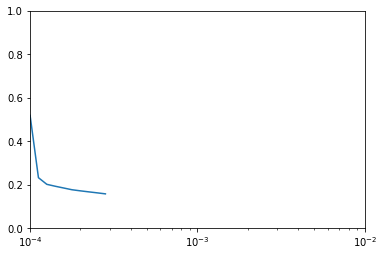

In [36]:
#Visualize learning rate vs epoches
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-2,0,1])

##4.2 Train the model with the optimal learning rate

In [0]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # EXERCISE: Use plt.savefig to save the plot to a PNG in memory.
    # YOUR CODE HERE
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # EXERCISE: Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # EXERCISE: Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image,0)
    
    return image

In [0]:
#https://axbihaqixpqbrrxincyxja.coursera-apps.org/notebooks/week3/TF_Serving_Week_3_Exercise_Question.ipynb

class_names = ['NO Afib','Afib']

def plot_confusion_matrix(cm, class_names, normalize=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.ylim(bottom=1.5,top = -0.5)
    
    if normalize:
      cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j], 
               horizontalalignment="center", 
               verticalalignment='center', 
               color="white" if cm[i, j] > threshold else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [0]:
def log_confusion_matrix(epoch, logs):
    
    # EXERCISE: Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test)
    
    test_pred = np.where(test_pred_raw > 0.5, 1, 0)
    
    # EXERCISE: Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=class_names, normalize = True)
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

### 4.2.2 Start Training

In [49]:
%%capture
#clear history if necessary
tf.keras.backend.clear_session()

#train model
learning_rate = 0.003 #choose the optimal learning rate
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) ##to overwrite NCCL cross device communication as this is running in Windows
with strategy.scope():

  model = model

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), 
              loss=tf.keras.losses.binary_crossentropy, 
              metrics=['accuracy'])

#callback: tensorboard
log_dir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#start training
model.fit(train_dataset,
          epochs=100,
          steps_per_epoch = len(list(train))/batch_size,
          verbose=0,
          validation_data=val_dataset,
          validation_steps = len(list(validation))/batch_size,
          callbacks=[tensorboard_callback, cm_callback]
          )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10


ValueError: ignored

In [45]:
tensorboard --logdir=log_dir

Reusing TensorBoard on port 6006 (pid 3240), started 0:03:25 ago. (Use '!kill 3240' to kill it.)

## 4.3 Save Model for future evaluation

In [0]:
!pip install -q pyyaml h5py

In [0]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model.save('Deep_ECG.h5')
print("Save model to disk")

# 5. Model Evaluation

## 5.1 Load saved model

In [0]:
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib_ECG data")
model = tf.keras.models.load_model('Deep_ECG.h5')

## 5.2 Confusion Matrix

In [0]:
threshold = 0.2
test_pred_raw = model.predict(test_signals)
test_pred = np.where(test_pred_raw > threshold, 1, 0)
# EXERCISE: Calculate the confusion matrix using sklearn.metrics
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
figure_norm = plot_confusion_matrix(cm, class_names=class_names, normalize=True)
figure_norm.show()
figure = plot_confusion_matrix(cm, class_names=class_names, normalize=False)
figure.show()

## 5.3 F-1 Score

In [0]:
report = sklearn.metrics.classification_report(test_labels, test_pred)

In [0]:
print(report)

## 5.4 AUC

In [0]:
score = sklearn.metrics.roc_auc_score(test_labels, test_pred)

In [0]:
print(score)

In [0]:
import sklearn.metrics as metrics
probs = model.predict_proba(test_signals)
preds = probs[:,]
fpr, tpr, threshold = metrics.roc_curve(test_labels, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()